# IX: The Hermit, Block 2
### Schrodinger's Cat or Not, classifier test 2
Scope: Test-classifier to see if a neural network can learn how to classify a 3x3 complex matrix as hermitian or not, and test on a 4x4

June 2, 2021

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [148]:
#@title Build Our Model
#@markdown We use a very simple neural network to keep things straightforward
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (4,4,2)), 
                                    tf.keras.layers.Dense(16, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
print(model.summary())
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
#@title Some Useful Custom Functions
#@markdown Hermiticity checker, random complex matrix generator

def is_hermitian(M: np.matrix):
    return np.allclose(M, M.H)

def rand_complex(N):
    '''
    Random complex matrix
    '''
    reals = np.random.random((N, N))
    imags = np.random.random((N, N)) * 1j

    mat = np.matrix(reals + imags)
    return mat / 3

import pandas as pd


def print_matrix(P):
    '''
    Just pretty prints matrices so that I can call it in one line
    '''
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
      print(pd.DataFrame(P))

In [4]:
#@title prefabbed code from SCoN
#@markdown Hermitian generator
def rand_diag(N):
    '''
    N Dimensional random trace-1 diagonal matrix via the following process:
        - Generate a random row vector
        - Divide by the sum to get trace-1
        - Return diagonal matrix
    '''
    diag_elements = np.random.random(N)
    return np.matrix(np.diag(diag_elements/sum(diag_elements)))


def rand_unitary(N):
    '''
    Random complex unitary matrix via the following process:
        - Generate a random complex matrix
        - Apply QR decomposition to get a unitary Q matrix
        - Return Q
    '''
    reals = np.random.random((N, N))
    imags = np.random.random((N, N)) * 1j

    a = reals + imags
    # Run QR decomposition to get unitary operator
    q, _ = np.linalg.qr(a)
    return np.matrix(q)


def rand_hermitian(N):
    '''
    Random trace-1 hermitian matrix of dimension N
    '''
    U = rand_unitary(N)
    H = rand_diag(N)

    return U * H * U.H

def extend_diagonal(matrix: np.matrix, n: int):
    '''
    Makes the matrix n dimensions bigger with new elements filled with zeroes
    '''
    new_dim = matrix.shape[0] + n
    new_mat = np.zeros((new_dim, new_dim)).astype(complex)
    new_mat[:matrix.shape[0], :matrix.shape[1]] = matrix
    return np.matrix(new_mat)


In [149]:
#@title Generate the Dataset
#@markdown Training with 500 matrices of each type
matrices = np.zeros((1000, 4, 4, 2))
results = np.zeros(1000)

for i in range(500):
  
  hermit = True
  while hermit:
    mat = rand_complex(3)
    hermit = is_hermitian(mat)
  matrices[2*i,:3,:3,0] = mat.real
  matrices[2*i,:3,:3,1] = mat.imag
  results[2*i] = 0

  H = rand_hermitian(3)
  matrices[2*i + 1,:3,:3,0] = H.real
  matrices[2*i + 1,:3,:3,1] = H.imag
  results[2*i + 1] = 1


In [55]:
#@title Show the matrices (optional)
#@markdown Get a graphical look at the matrices
import time
from IPython.display import clear_output 

def show_matrix(n):
  print("Real Component")
  fig, ax = plt.subplots()

  ax.matshow(matrices[n, :, :, 0], cmap=plt.cm.coolwarm)
  
  for i in range(4):
      for j in range(4):
          c = round(matrices[n, j,i, 0], 2)
          ax.text(i, j, str(c), va='center', ha='center')
  plt.show()

  print("Imaginary Component")
  fig, ax = plt.subplots()
  ax.matshow(matrices[n, :, :, 1], cmap=plt.cm.coolwarm)

  for i in range(4):
      for j in range(4):
          c = round(matrices[n, j,i, 1], 2)
          ax.text(i, j, str(c), va='center', ha='center')
  plt.show()

for i in range(1, 200, 2):
    show_matrix(i)
    time.sleep(1)
    clear_output()

In [159]:
history = model.fit(x=matrices, y=results, verbose=1)

32/32 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 1.0000


Hermiticity: 98.908531665802 %
                    0                   1                   2  \
0  0.418374-0.000000j  0.164814-0.075563j  0.012976-0.051314j   
1  0.164814+0.075563j  0.125933+0.000000j  0.080998+0.110413j   
2  0.012976+0.051314j  0.080998-0.110413j  0.455694+0.000000j   
3  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000+0.000000j  
2  0.000000+0.000000j  
3  0.000000+0.000000j  
Hermiticity: 99.71912503242493 %
                    0                   1                   2  \
0  0.342311+0.000000j -0.079992+0.027135j -0.102320-0.027867j   
1 -0.079992-0.027135j  0.284973+0.000000j -0.023901+0.034047j   
2 -0.102320+0.027867j -0.023901-0.034047j  0.176284+0.000000j   
3  0.009967+0.000590j  0.035510-0.030634j  0.091417-0.045880j   

                    3  
0  0.009967-0.000590j  
1  0.035510+0.030634j  
2  0.091417+0.045880j  
3  0.196432-0.000000j  


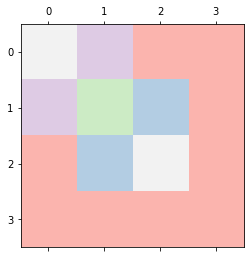

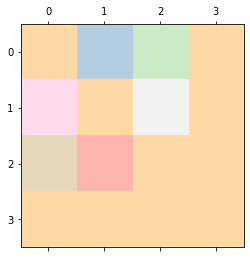

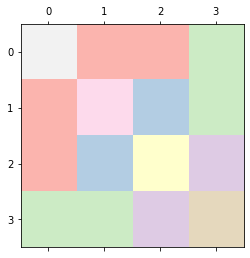

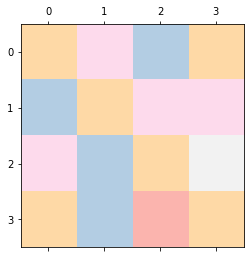

In [161]:
#@title Validate our results
#@markdown Generate 1 Hermitian and 1 random (probably non-hermitian) matrix to test!

from matplotlib import pyplot as plt

mat = extend_diagonal(rand_hermitian(3), 1)
bad = rand_hermitian(4)

bruh = np.empty((2, 4, 4, 2))

bruh[0,:,:,0] = mat.real
bruh[0,:,:,1] = mat.imag

bruh[1,:,:,0] = bad.real
bruh[1,:,:,1] = bad.imag

# Try to perturb the system
# bruh[0,0,2,1] = 0.5
# bruh[0,2,0,1] = 0.5

prediction = model.predict(bruh)

print("Hermiticity:", prediction[0][0]*100, "%")
print_matrix(mat)
plt.matshow(bruh[0,:,:,0], cmap=plt.cm.Pastel1)
plt.matshow(bruh[0,:,:,1], cmap=plt.cm.Pastel1)

print("Hermiticity:", prediction[1][0]*100, "%")
print_matrix(bad)
plt.matshow(bruh[1,:,:,0], cmap=plt.cm.Pastel1)
plt.matshow(bruh[1,:,:,1], cmap=plt.cm.Pastel1)

In [167]:
# Try to perturb the system
bruh[0,0,2,1] = 0.5
bruh[0,2,0,1] = 0

bruh[1,0,2,1] = 0.5
bruh[1,2,0,1] = 0

bruh[1,0,3,1] = 0.5
bruh[1,3,0,1] = 0.5

prediction = model.predict(bruh)

print(is_hermitian(np.matrix(bruh[0, :, :, 0] + 1j*bruh[0, :, :, 1])))

print("Hermiticity:", prediction[0][0]*100, "%")
print_matrix(mat)

print(is_hermitian(np.matrix(bruh[1, :, :, 0] + 1j*bruh[1, :, :, 1])))
print("Hermiticity:", prediction[1][0]*100, "%")
print_matrix(bad)

False
Hermiticity: 92.2925591468811 %
                    0                   1                   2  \
0  0.418374-0.000000j  0.164814-0.075563j  0.012976-0.051314j   
1  0.164814+0.075563j  0.125933+0.000000j  0.080998+0.110413j   
2  0.012976+0.051314j  0.080998-0.110413j  0.455694+0.000000j   
3  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000+0.000000j  
2  0.000000+0.000000j  
3  0.000000+0.000000j  
False
Hermiticity: 95.72951793670654 %
                    0                   1                   2  \
0  0.342311+0.000000j -0.079992+0.027135j -0.102320-0.027867j   
1 -0.079992-0.027135j  0.284973+0.000000j -0.023901+0.034047j   
2 -0.102320+0.027867j -0.023901-0.034047j  0.176284+0.000000j   
3  0.009967+0.000590j  0.035510-0.030634j  0.091417-0.045880j   

                    3  
0  0.009967-0.000590j  
1  0.035510+0.030634j  
2  0.091417+0.045880j  
3  0.196432-0.000000j  


False

# Conclusion
For 4x4 matrices, the network is not as sensitive